In [1]:
import sys
sys.path.append('../../code/')

In [2]:
%load_ext autoreload
%autoreload 2

from libs import io
from libs import constants
from libs import vis
from libs import helpers
from libs.metrics import aggregators
from libs.metrics import helpers as helpers_metrics
from postprocessing import factuality
from postprocessing import bias

Available LLMs: (24): llama-3.3-8b llama-4-scout llama-4-mav gpt-oss-20b gpt-oss-120b qwen3-8b qwen3-14b qwen3-32b qwen3-30b-a3b-2507 qwen3-235b-a22b-2507 gemma-3-12b gemma-3-27b mistral-small-3.2-24b mistral-medium-3 llama-3.1-70b llama-3.3-70b llama-3.1-405b grok-4-fast deepseek-chat-v3.1 deepseek-r1-0528 gemini-2.5-flash gemini-2.5-flash-grounded gemini-2.5-pro gemini-2.5-pro-grounded


# Setup

In [3]:
APS_OA_DATA_TAR_GZ = '../../../APS/data/final_dataset.tar.gz'
APS_OS_DISCIPLINE_DEMOGRAPHICS = '../../results/interventions/metadata/disciplines_author_demographics.csv'

DATA_PATH = '../../results/temperature-analysis'
SUMMARY_PATH = io.path_join(DATA_PATH, 'summaries')
VALID_RESPONSES_PATH = io.path_join(DATA_PATH, 'valid_responses')
FACTUALITY_RESPONSES_PATH = io.path_join(DATA_PATH, 'factuality')

RESULTS_PATH = '../../results/interventions'
PLOTS_PATH = io.path_join(RESULTS_PATH, 'plots')    
TABLES_PATH = io.path_join(RESULTS_PATH, 'tables')
LATEX_PATH = io.path_join(RESULTS_PATH, 'latex')

io.validate_path(PLOTS_PATH)
io.validate_path(TABLES_PATH)
io.validate_path(LATEX_PATH)


# Data

In [5]:
# Load the summary data for each model (all outputs)
df_summary_all = io.pd.concat([io.read_csv(io.path_join(SUMMARY_PATH, f"experiments_{model}.csv"), low_memory=False) for model in constants.LLMS], ignore_index=True)
df_valid_responses_all = io.pd.concat([io.read_csv(io.path_join(VALID_RESPONSES_PATH, f"{model}.csv"), index_col=0, low_memory=False) for model in constants.LLMS], ignore_index=True)
df_factuality_author_all = io.pd.concat([io.read_csv(io.path_join(FACTUALITY_RESPONSES_PATH, f"{model}_author.csv"), index_col=0, low_memory=False) for model in constants.LLMS], ignore_index=True)

df_summary_all.shape, df_valid_responses_all.shape, df_factuality_author_all.shape
# ((26789, 20), (521942, 17), (521942, 36))


((26789, 20), (521942, 17), (521942, 36))

In [8]:
# demographics
df_all_authors_demographics = io.read_file_from_tar_gz_as_dataframe(APS_OA_DATA_TAR_GZ, constants.APS_OA_AUTHORS_DEMOGRAPHICS_FN)
df_all_authors_demographics.rename(columns={'id_author':'id_author_oa'}, inplace=True)

# scholarly stats
df_all_authors_stats = io.read_file_from_tar_gz_as_dataframe(APS_OA_DATA_TAR_GZ, constants.APS_OA_AUTHORS_STATS_FN)
df_all_authors_stats.rename(columns={'id_author':'id_author_oa'}, inplace=True)

# per discipline
df_gt_stats = io.read_csv(APS_OS_DISCIPLINE_DEMOGRAPHICS, index_col=0, header=[0, 1])

# gt (from APS)
df_gt = df_all_authors_demographics[['id_author_oa','first_name','last_name','ethnicity','gender']].copy()
df_gt = df_gt.merge(df_all_authors_stats[['id_author_oa','works_count','cited_by_count', 'rr1_rank_publications','rr1_rank_publications_percentile', 'rr2_rank_citations','rr2_rank_citations_percentile']], on='id_author_oa', how='left')
df_gt = helpers.add_quantiles(df_gt)

# shapes
df_all_authors_demographics.shape, df_gt_stats.shape, df_gt_stats.shape, df_gt.shape

((481012, 14), (17, 19), (17, 19), (481012, 13))

## Augmenting data

In [9]:
# adding prominence metrics to recommended authors
df_factuality_author_all = df_factuality_author_all.merge(df_gt[['id_author_oa', 'prominence_pub', 'prominence_cit']], on='id_author_oa', how='left')

# adding infrastructure metadata
df_summary_all = helpers.add_infrastructure_columns(df_summary_all)
df_factuality_author_all = helpers.add_infrastructure_columns(df_factuality_author_all)

# shapes
df_summary_all.shape, df_factuality_author_all.shape


((26789, 25), (521942, 43))

# Metrics

In [24]:
# ALL data
prefix = 'temperature'

_ = helpers_metrics.load_per_attempt('validity_pct', df_summary_all, TABLES_PATH, prefix=prefix)
_ = helpers_metrics.load_per_attempt('factuality_author', df_factuality_author_all, TABLES_PATH, prefix=prefix)
_ = helpers_metrics.load_per_attempt('duplicates', df_factuality_author_all, TABLES_PATH, prefix=prefix)
_ = helpers_metrics.load_per_attempt('refusal_pct', df_summary_all, TABLES_PATH, prefix=prefix)
_ = helpers_metrics.load_per_attempt('consistency', df_factuality_author_all, TABLES_PATH, prefix=prefix)

_ = helpers_metrics.load_per_attempt('diversity_gender', df_factuality_author_all, TABLES_PATH, prefix=prefix)
_ = helpers_metrics.load_per_attempt('diversity_ethnicity', df_factuality_author_all, TABLES_PATH, prefix=prefix)
_ = helpers_metrics.load_per_attempt('diversity_prominence_pub', df_factuality_author_all, TABLES_PATH, prefix=prefix)
_ = helpers_metrics.load_per_attempt('diversity_prominence_cit', df_factuality_author_all, TABLES_PATH, prefix=prefix)

_ = helpers_metrics.load_per_attempt('parity_gender', df_factuality_author_all, TABLES_PATH, gt=df_gt, prefix=prefix)
_ = helpers_metrics.load_per_attempt('parity_ethnicity', df_factuality_author_all, TABLES_PATH, gt=df_gt, prefix=prefix)
_ = helpers_metrics.load_per_attempt('parity_prominence_pub', df_factuality_author_all, TABLES_PATH, gt=df_gt, prefix=prefix)
_ = helpers_metrics.load_per_attempt('parity_prominence_cit', df_factuality_author_all, TABLES_PATH, gt=df_gt, prefix=prefix)


# Plots

In [4]:
# filter out interventions
query_infra = "task_name != @constants.EXPERIMENT_TASK_BIASED_TOP_K and grounded == False"

In [5]:
vis.sns_reset()
vis.sns_paper_style(font_scale=1.55)

In [6]:
FIGSIZE = (10, 2.25)
FIGSIZE_TOP = (10, 2.5)
PLOT_KWARGS = {'figsize':FIGSIZE, 'ylim':(0, 1), 'show_xticks':True, 'show_xlabel':True}
PLOT_KWARGS_TOP = {'figsize':FIGSIZE_TOP, 'ylim':(0, 1), 'show_title':True, 
                  'show_xticks':True, 'show_xlabel':True, 'show_legend':True, 'legend_kwargs':{'loc':'best'}}

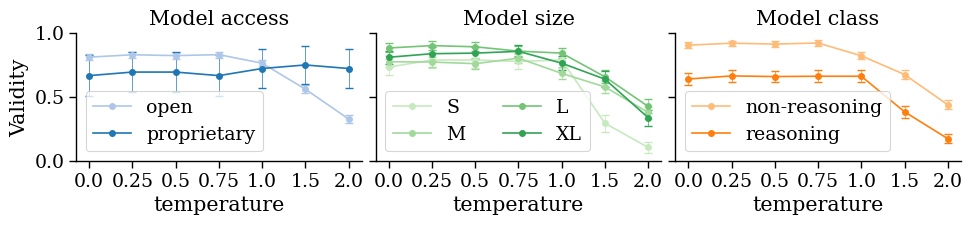

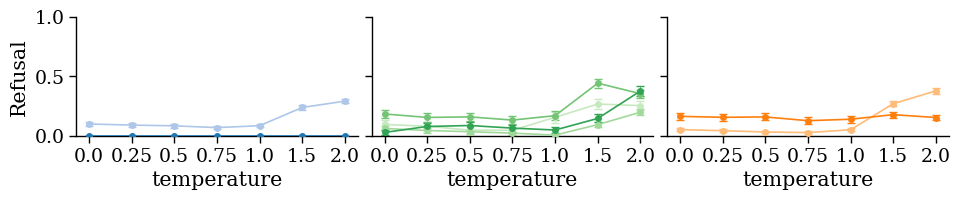

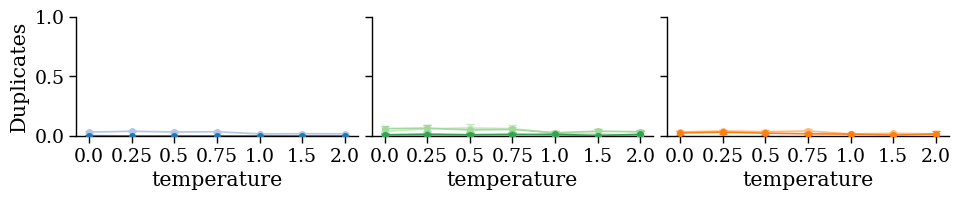

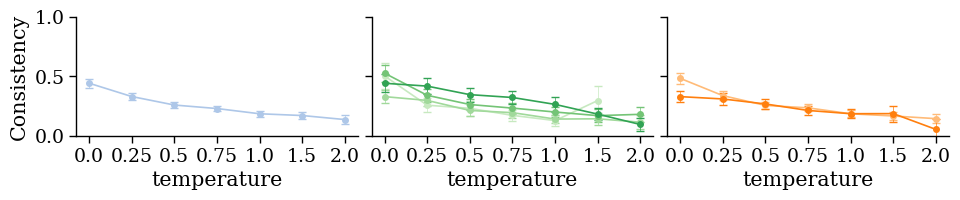

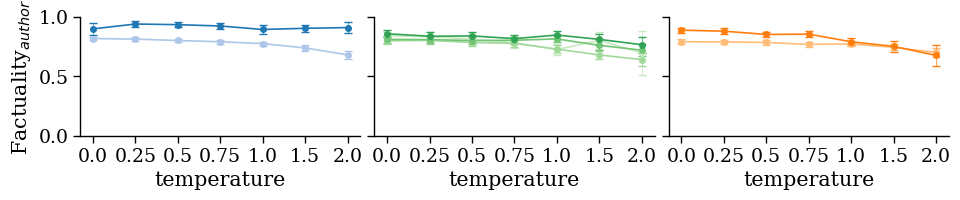

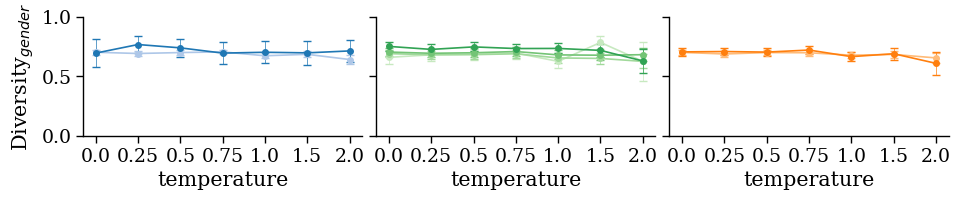

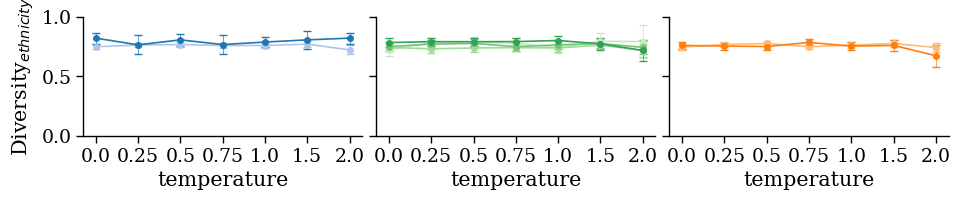

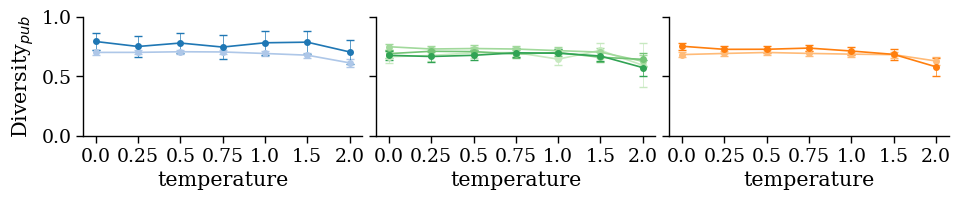

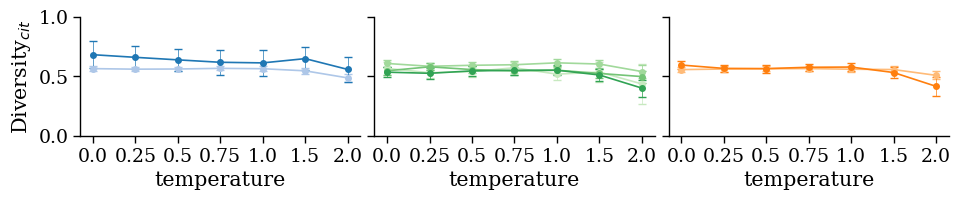

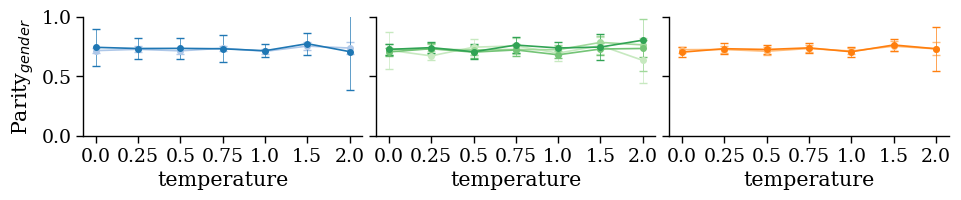

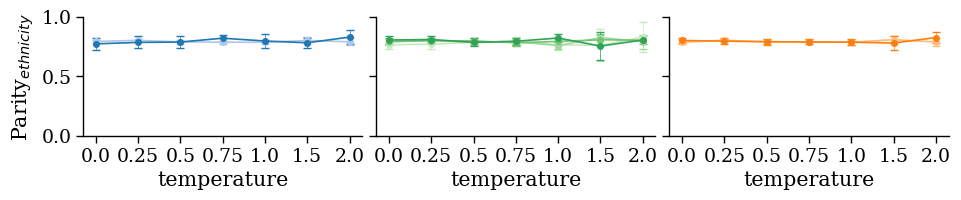

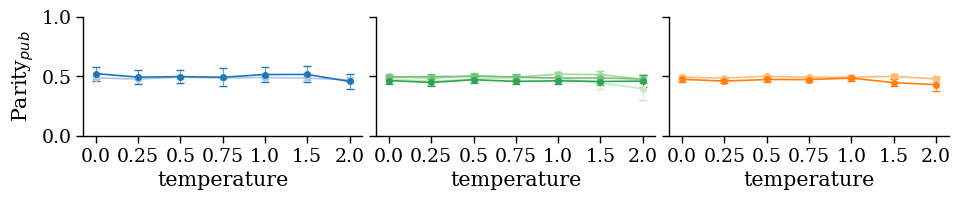

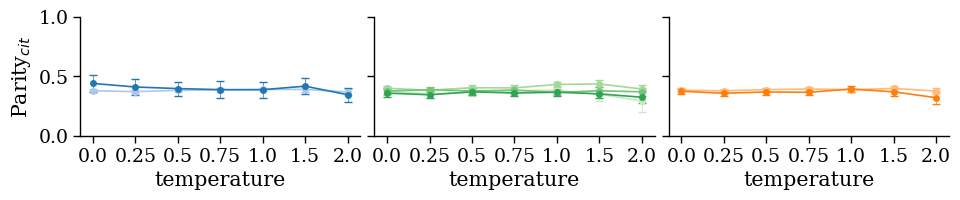

In [7]:
xvar = 'temperature'
for i, metric in enumerate(helpers_metrics.METRICS):
    fn = helpers_metrics.get_plot_fn(metric, PLOTS_PATH, prefix=xvar)
    per_attempt = helpers_metrics.load_per_attempt(metric, None, TABLES_PATH, prefix=xvar).query(query_infra)
    per_attempt = helpers.add_infrastructure_columns(per_attempt)
    vis.plot_infrastructural_conditions_by_intervention(per_attempt, fn=fn, xvar=xvar, ylabel=metric, **PLOT_KWARGS_TOP if i == 0 else PLOT_KWARGS)
